# Introduction to MCMC
MCMC stands for Markov-Chain Monte Carlo, and is a method for fitting models to data. More accurately, MCMCs are a class of method used to numerically perform multidimensional integrals, usually estimating integrals like $$\int f(\theta) p(\theta| D)d\theta$$ but it does so indirectly by generating samples whose empirical average approximates the integral.
While MCMC itself does not “fit” models in the optimization sense, it is widely used to estimate posterior distributions of model parameters, making it a fundamental tool for statistical inference.

Notation definition:
* $\theta$ - model parameter you're interested in (could be a single data or a high-dimensional vector).
* $p(\theta | D)$ - The posterior distribution of the parameter given data, usually proportional to likelihood $p(D|\theta)$ and prior $p(\theta)$ using Bayes' rule, i.e. $p(\theta | D) \propto p(D|\theta) p(\theta)$.
* $f(\theta)$ - Any function of the model parameter $\theta$ whose expectation with respect to the posterior distribution $p(\theta|D)$ you want to compute.

Note that the posterior $p(\theta|D)$ tells you the plausibility of each value $\theta$ is given the data $D$, and the expectation $\int f(\theta) p(\theta| D)d\theta$ is the numerical quantity MCMC helps approximate.

## Simple Example 
by Imad Pasha [(blog link)](https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html)

Located in this directory is a file containing the temperature change, age, deuterium content, etc., of the Earth’s atmosphere over the last several million years, calculated from measurements of ice-core samples. For the purposes of this tutorial, we will be interested in only the age and temperature columns.
The file is called ‘ice_core_data.txt’, and the ages and 
$\Delta T$ are in the third and fifth columns, respectively. Load the data and plot the Temperature deviation (from average) against age to see what we will be trying to fit in this tutorial.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

ice_data = np.genfromtxt('./data/ice_core_data.txt')[:,[2,4]]

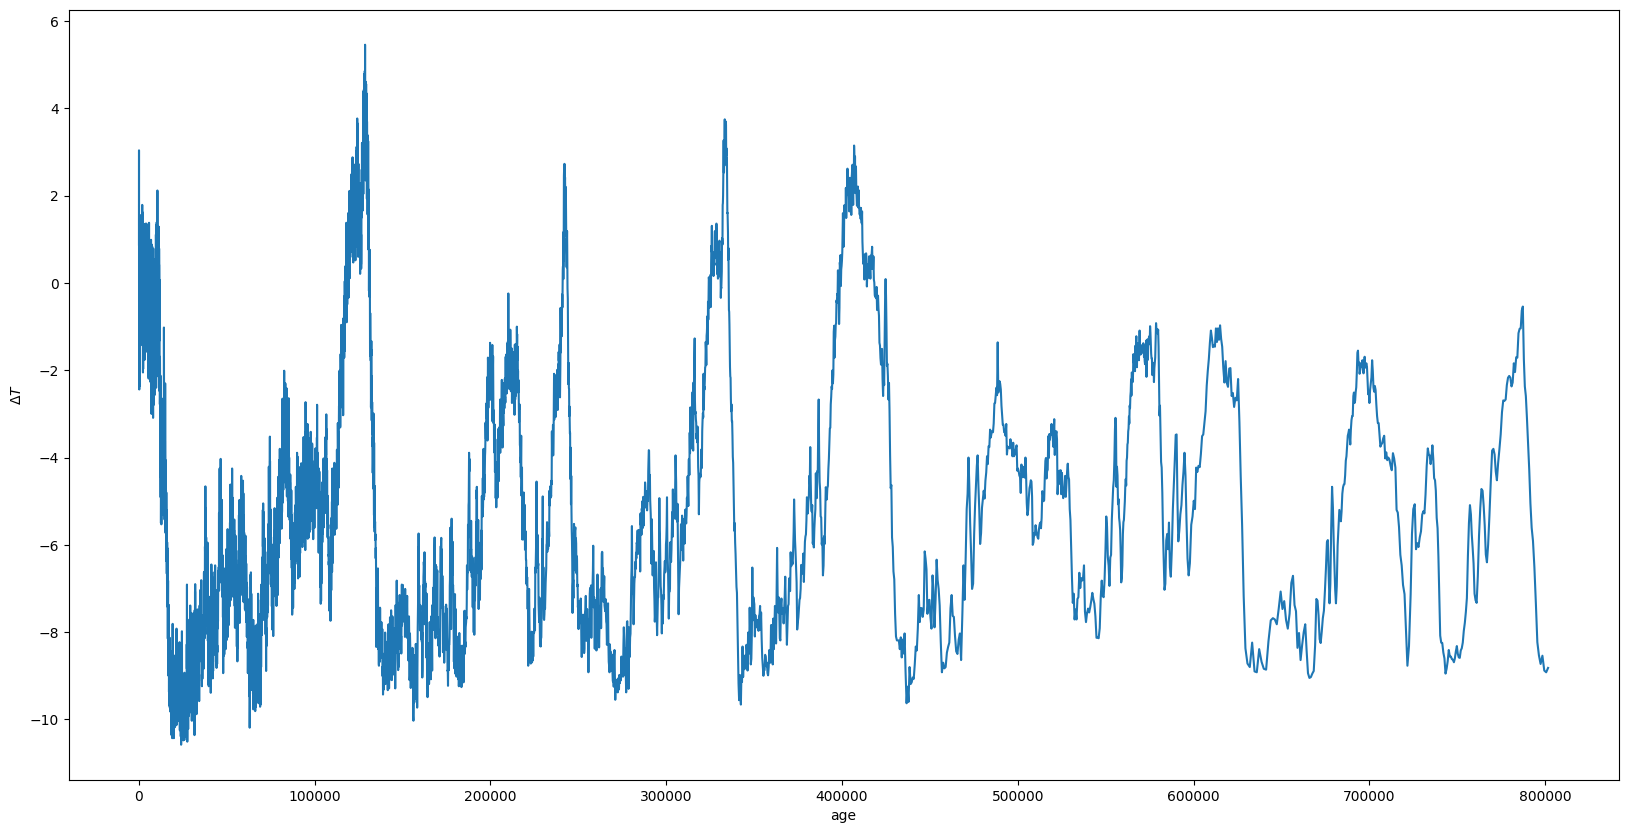

In [80]:
ice_data = np.genfromtxt('./data/ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()

Great. Now, we can see that the temperature of Earth fluctuates a lot over its history, but that those fluctuations seem fairly periodic. It turns out, these fluctuations are due to combinations of small, but important periodic changes in the Earth’s tilt (obliquity), rotational precession, orbital precession, eccentricity, and ecliptic inclination. Three of these effects were studied extensively by Milutin Milankovich and have come to be named after him. While not the only effects, they are three of the primary ones driving the fluctuations we see above.

Those three effects are the obliquity, rotational precession, and eccentricity. For more on these effects, you can check out the wikipedia article: https://en.wikipedia.org/wiki/Milankovitch_cycles

From the article, we can see that the periods of the Milankovich cycles are approximately 26,000 years, 41,000 years, and 100,000 years. While our model will actually end up fitting our periods for us, but having these numbers in mind will allow us to shorten our MCMC run by introducing good priors, which are a priori limitations on the allowed parameter values. For example, if you are simulating galaxy spectra, the age of the galaxy as a free parameter should not be allowed to be greater than the age of the universe. Why let the MCMC spend the time fitting models that are unphysical anyway?

We can create a basic model for describing the above fluctuations as a sum of three sinusoids, which have different amplitudes and periods corresponding to roughly the Milankovich cycles. This won’t work perfectly, but will be good enough for our purposes. Our model will be of the form
$$\Delta T = a_1 \sin \left(\frac{2\pi t}{p_1}\right) + a_2 \sin \left(\frac{2\pi t}{p_2}\right) + a_3 \sin \left(\frac{2\pi t}{p_3}\right) + T_0$$
where $a_1, a_2, a_3, p_1, p_2,p_3,$ and $T_0$ are parameters being fitted.



We will be creating four functions for this MCMC run. The first is straightforward, and is known as the model. For completion, your model function should also have your age array as an input, which here we can set to default to the age array defined above. Create your function below:

In [81]:
def model(theta, age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    # enter your model here
    T = T0 + a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3)
    return T

We now need a function referred to as lnlike(). This function takes as an argument theta as well as the 
$x$, $y$, and $y_{err}$ of your actual $\theta$. It’s job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points (i.e. it is more important the fit be close to data points with small error bars than points with large error bars). We will use the following formulation to determine this number- translate it to a function in python below:

In [42]:
def lnlike(theta, x, y, yerr):
    if x.shape != y.shape or x.shape != yerr.shape:
        # check that x, y, yerr have same length
        raise ValueError('x, y, yerr must have same length')
    if np.any(yerr == 0):
        # check for zero errors
        raise ValueError('yerr must not contain zeros')
    LnLike = -0.5*np.sum((y-model(theta,x))**2/yerr**2)
    return LnLike

The next function we need is one to check, before running the probability function (last one defined) on any set of parameters, that all variables are within their priors (in fact, this is where we set our priors).

The output of this function is totally arbitrary (it is just encoding True False), but emcee asks that if all priors are satisfied, 0.0 is returned, otherwise return -np.inf. Its input is a $\theta$ vector.

In [92]:
def lnprior(theta, Amax = 5, T_min = -10, T_max = 0, mu_periods = (23000, 41000, 100000), tol_period = 10000):
    a1, a2, a3, p1, p2, p3, T0 = theta
    # if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
    #     return 0.0
    # return -np.inf


    # Amplitude bounds
    if not (0 < a1 < Amax and 0 < a2 < Amax and 0 < a3 < Amax):
        return -np.inf
    # Period bounds
    for p, mu in zip((p1, p2, p3), mu_periods):
        if not (mu - tol_period <= p <= mu + tol_period):
            return -np.inf
    
    # T0 bounds
    if not (T_min <= T0 <= T_max):
        return -np.inf

    return 0.0


The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it’s the lnprior output + lnlike output, since lnprior’s output should be zero if the priors are good).

In [93]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): # check if prior is valid
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)  #recall if lp not -inf, its 0, so this just returns likelihood

We have one or two steps left before we can run. First, our Temperature measurements, unfortunately, have no errors provided. But we need errors for the MCMC to run, so let’s set a yerr array arbitrarily to 5% of the average temperature in our temperature array.

We will want to feed our data (x,y,yerr) in as a tuple, so set data equal to a tuple of our age, temperature and temperature error arrays.

We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let’s use 500.

We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). *2020 Update: Foreman-Mackey & Hogg recommend that in many cases, running an optimizer first (e.g., from scipy) is the best way to select an initial starting value.

Finally we need p0, which is the methodology of stepping from one place to a grid to the next ( I will provide this). For those interested, this is a multivariate Gaussian centered on each theta, with a small $\sigma$. Thus, the proposed move for each walker is general some place in N-dimensional parameter space very close to the current location.

In [127]:
Terr = 0.05*np.mean(T)*np.ones_like(T)
data = (age, T,Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [128]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [129]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [130]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

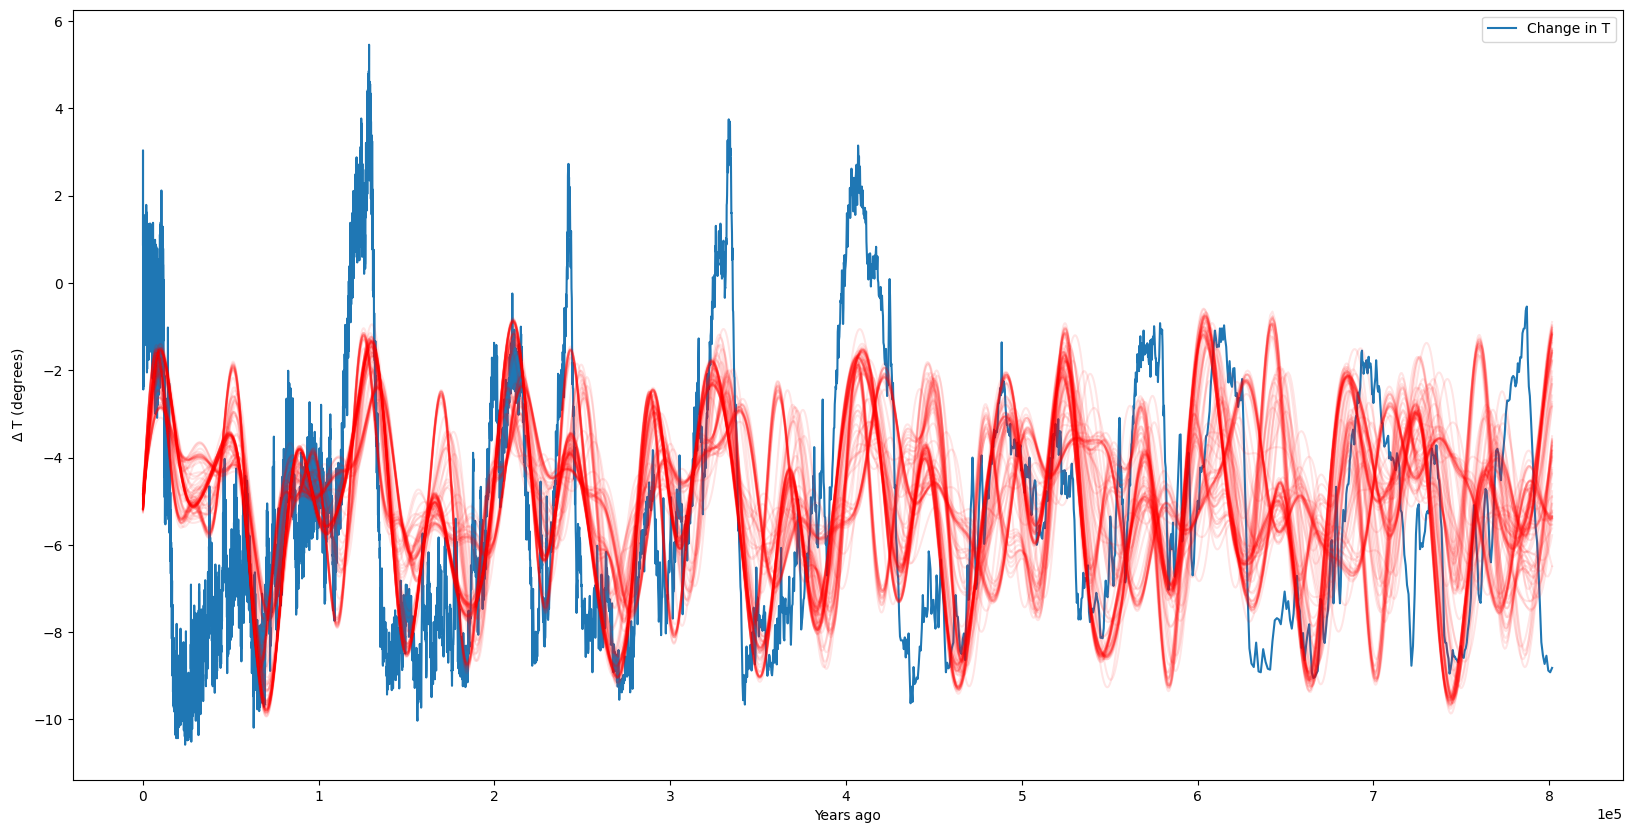

In [112]:
plotter(sampler)

In [113]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 5.03237624e-01,  2.21098447e+00,  2.06198916e+00,  2.50782339e+04,
        3.95815406e+04,  9.61196301e+04, -5.33049310e+00])

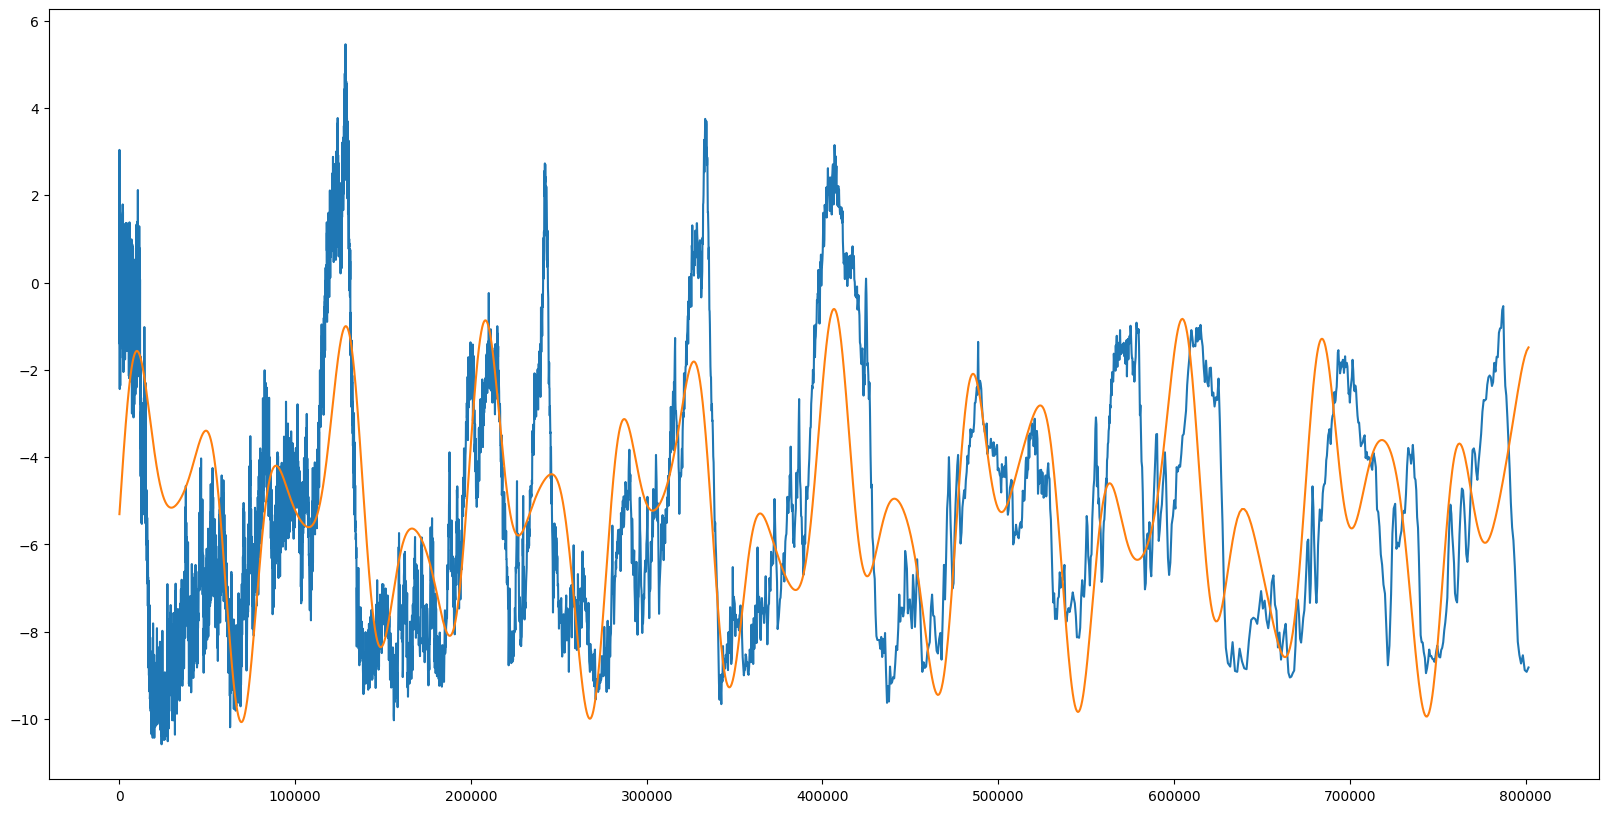

Theta max:  [ 5.03237624e-01  2.21098447e+00  2.06198916e+00  2.50782339e+04
  3.95815406e+04  9.61196301e+04 -5.33049310e+00]


In [114]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

## Posterior Spread

We can use the corner.py module to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations.

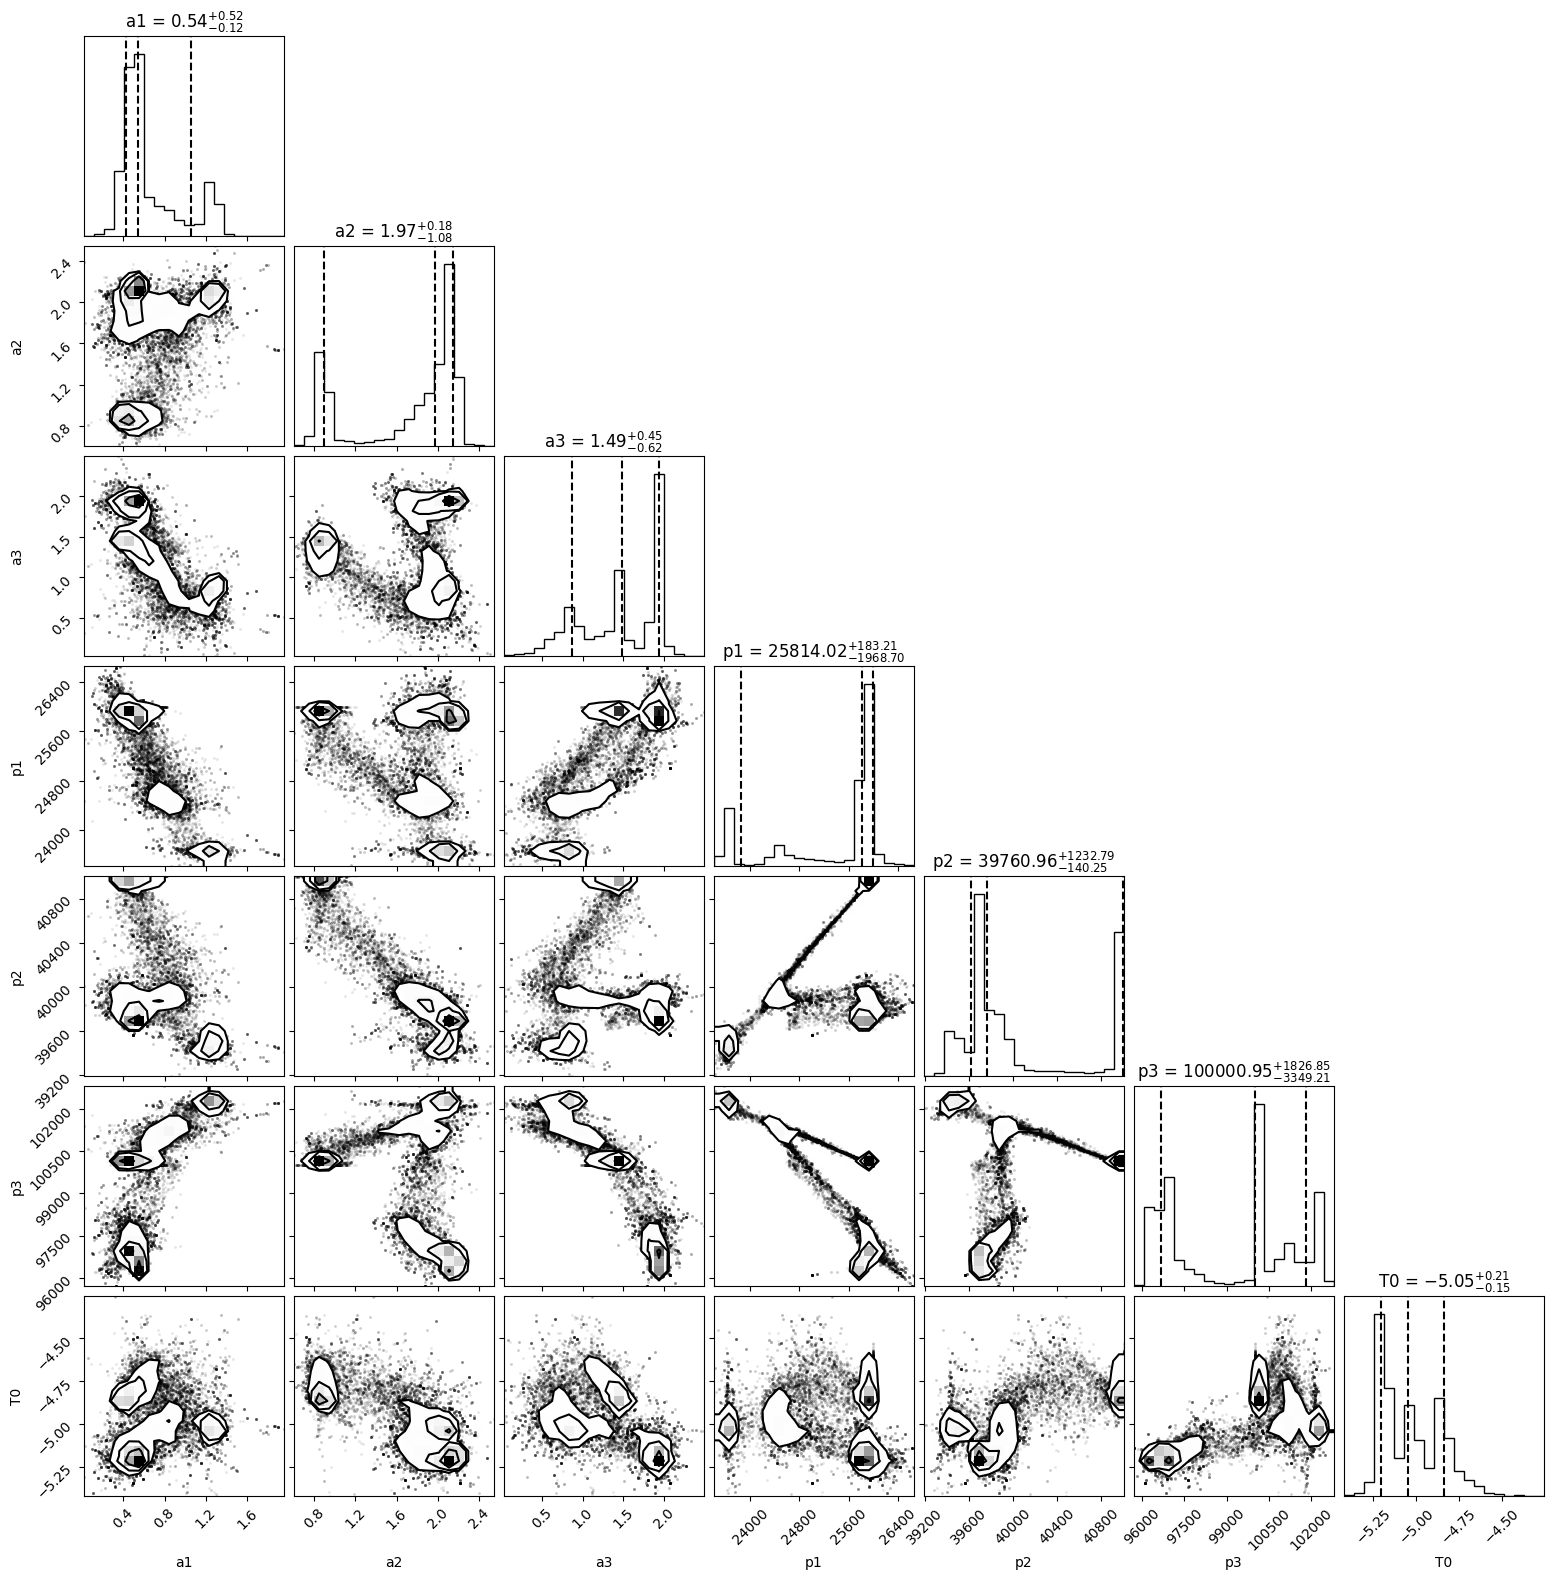

In [131]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [124]:
Terr = 0.05*np.mean(T)*np.ones_like(T)
data = (age, T,Terr)
nwalkers = 500
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


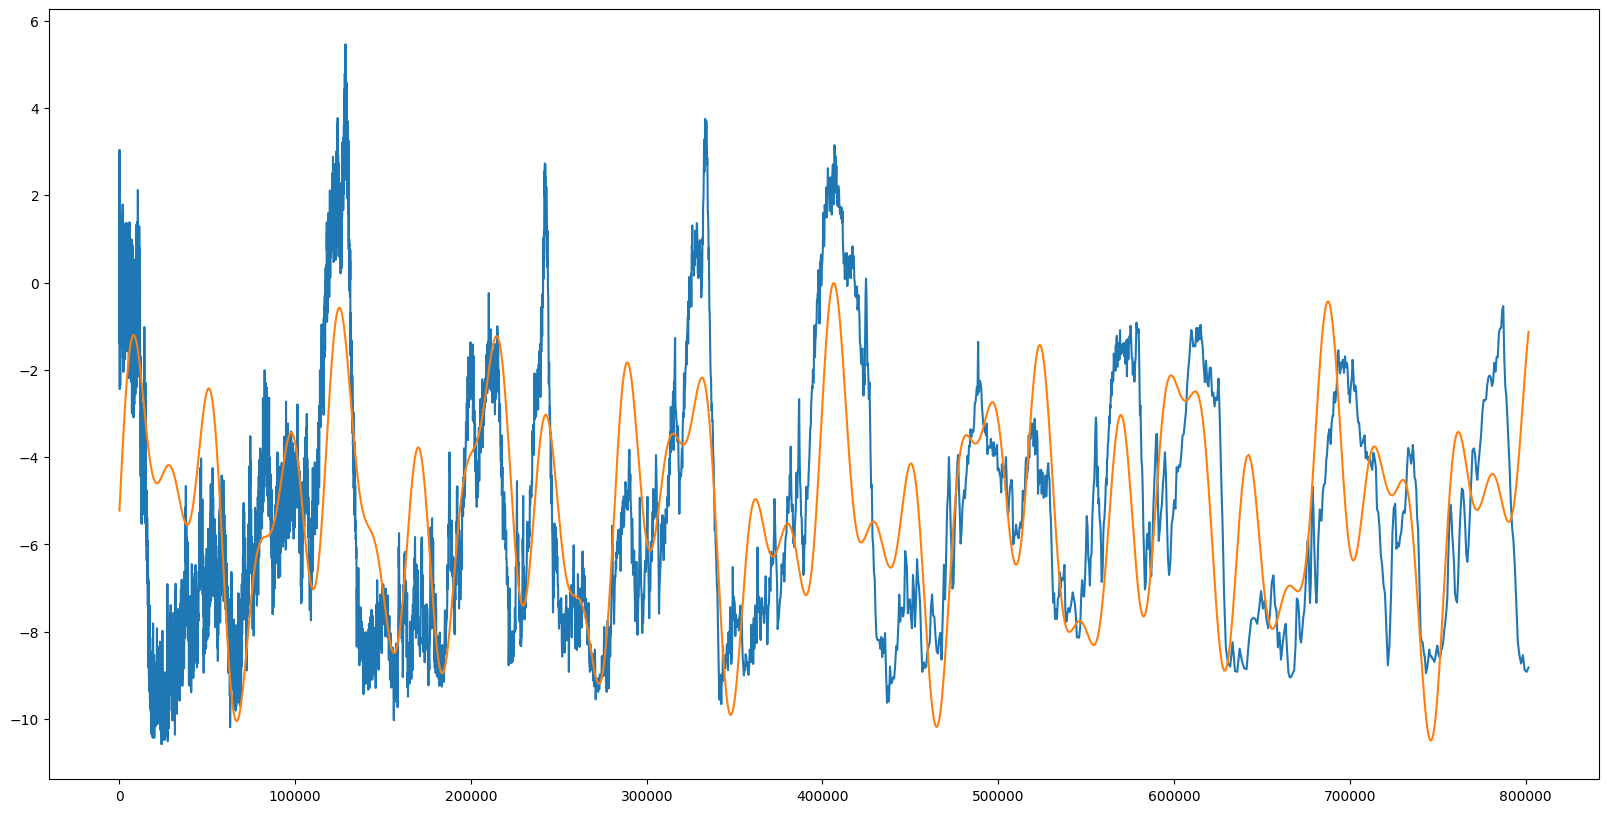

Theta max:  [ 1.32737862e+00  2.08075570e+00  1.89632060e+00  2.35215988e+04
  3.97326296e+04  9.61378411e+04 -5.25507621e+00]


In [125]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print('Theta max: ',new_theta_max)

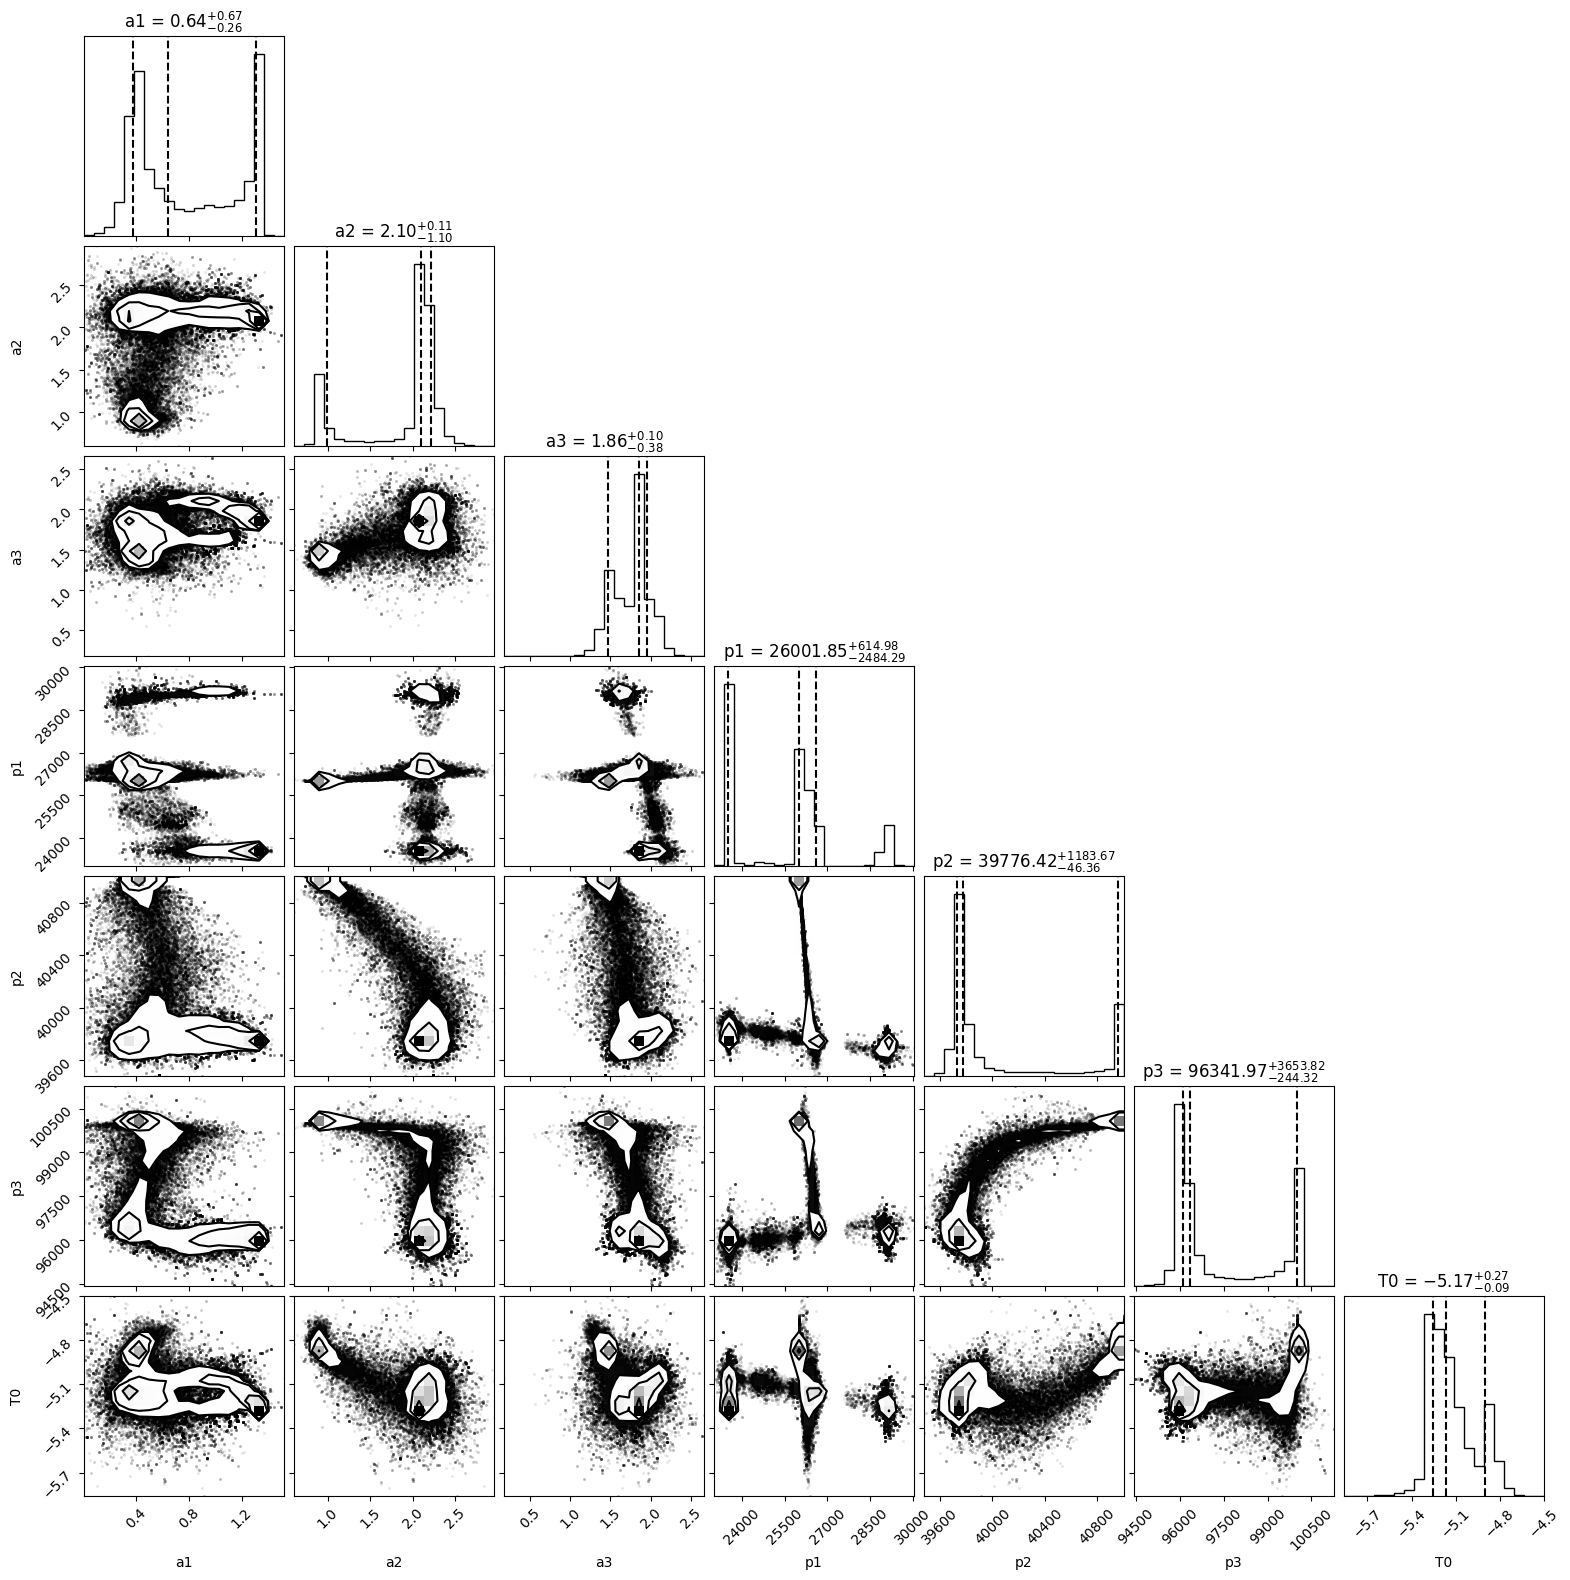

In [134]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [135]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

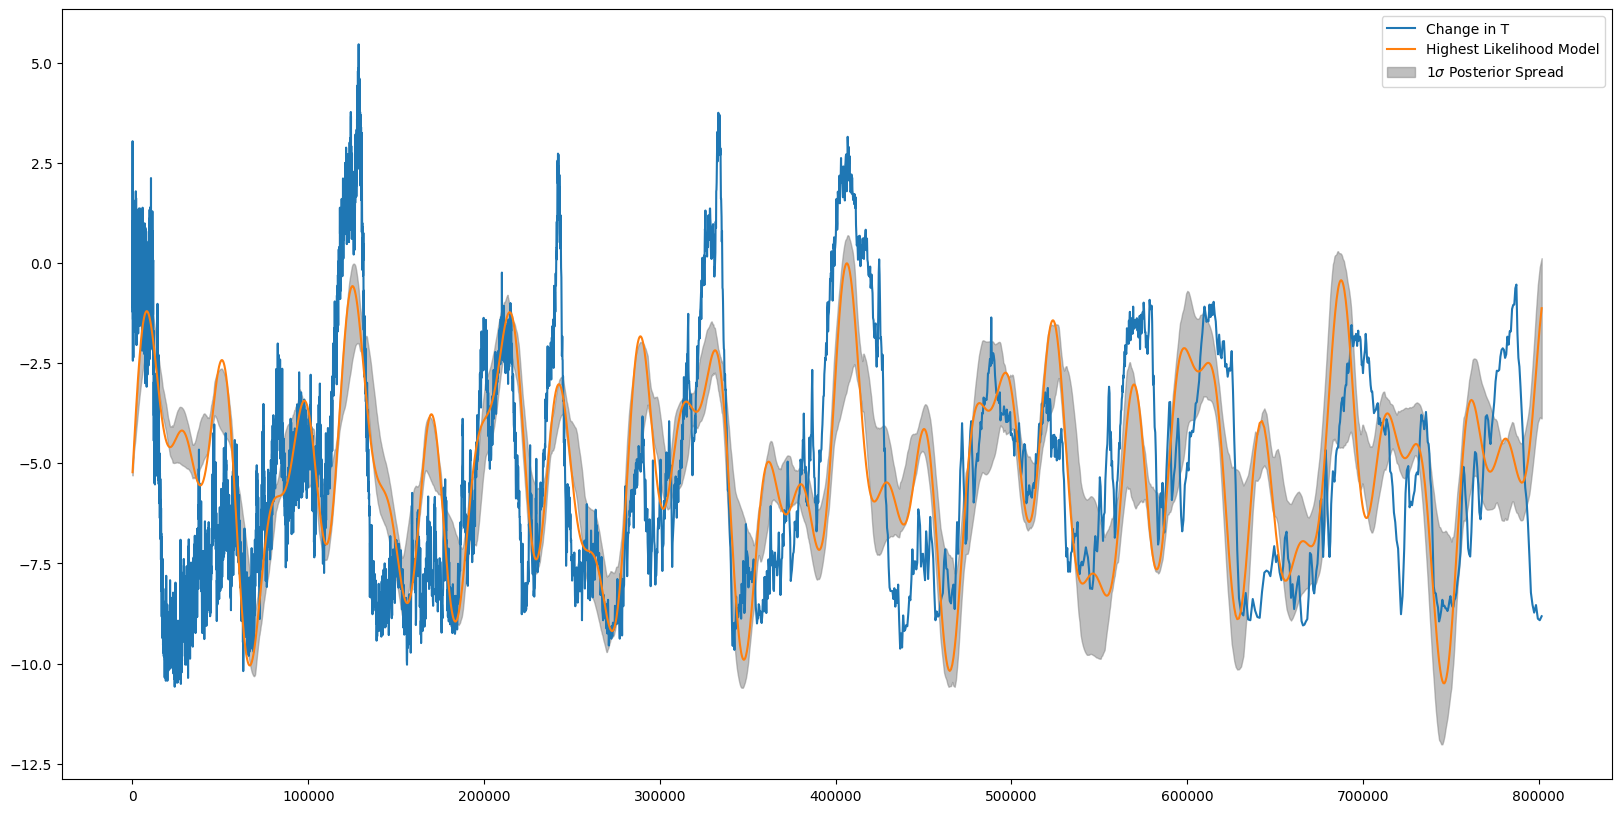

In [136]:
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()